In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import networkx as nx

### Load the dataset

In [5]:
# The column names for the dataset
# They are not provided in the original code, so we define them here.

COLS = [
    "unit", "cycle",
    "setting1", "setting2", "setting3",
    "T2", "T24", "T30", "T50", "P2", "P15", "P30",
    "Nf", "Nc", "EPR", "Ps30", "Phi", "NRf", "NRc",
    "BPR", "farB", "htBleed", "Nf_dmd", "PCNf_Rdmd", "W31", "W32"
]

In [6]:
# Importing the train dataset

df = pd.read_csv(
    "data/train_FD001.txt",
    delim_whitespace=True,   # gère les espaces multiples
    header=None,             # pas d’entêtes dans le .txt
    names=COLS,              # on assigne notre liste
    usecols=range(len(COLS)) # ignore les colonnes vides finales
)

df.head()

C:\Users\Samue\AppData\Local\Temp\ipykernel_23908\237424015.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,unit,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,Phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNf_Rdmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
# Importing the test dataset

df_test = pd.read_csv(
	"data/test_FD001.txt",
	delim_whitespace=True,
	header=None,
	names=COLS,
	usecols=range(len(COLS))
)

df_test.head()

C:\Users\Samue\AppData\Local\Temp\ipykernel_23908\2599212678.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv(


,unit,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,Phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNf_Rdmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [8]:
def add_rul(df):
    temp = df.groupby('unit')['cycle'].max().reset_index()
    temp.columns = ['unit', 'max_cycle']
    df = df.merge(temp, on='unit')
    df['RUL'] = df['max_cycle'] - df['cycle']
    return df.drop('max_cycle', axis=1)

# Adding RUL to the train and test datasets
df = add_rul(df)
df_test = add_rul(df_test)

df.head()

,unit,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNf_Rdmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Calcul Remaining Useful Life (RUL) to labelised the cycles

In [24]:
WINDOW = 25     # window length
HORIZON = 50    # alert if RUL ≤ HORIZON

def flag_window(win, p10, p90):
	"""
	Converts a window (DataFrame) into a set of readable 'binary features'.
	"""
	fset = set()
	for col in SENSOR_COLS:
		series = win[col]
		# Static: extreme values
		if series.mean() >= p90[col]:
			fset.add(f"{col}_High")
		elif series.mean() <= p10[col]:
			fset.add(f"{col}_Low")
		# Dynamic: trend
		slope = series.iloc[-1] - series.iloc[0]
		if slope > 0:
			fset.add(f"{col}_Rising")
		elif slope < 0:
			fset.add(f"{col}_Falling")
	return fset

SENSOR_COLS = ['T2','T24','T30','T50','P2','P15','P30',
			   'Nf','Nc','EPR','Ps30','Phi','NRf','NRc',
			   'BPR','farB','htBleed','Nf_dmd','PCNf_Rdmd','W31','W32']
p10 = df[SENSOR_COLS].quantile(0.10)
p90 = df[SENSOR_COLS].quantile(0.90)

df_all = df.copy()          # save

transactions = []
labels = []
unit_ids = []
start_indices = []

for uid, df_unit in tqdm(df_all.groupby('unit')):
	for start in range(0, len(df_unit) - WINDOW + 1):
		win = df_unit.iloc[start:start+WINDOW]
		transactions.append(flag_window(win, p10, p90))
		label = "Fail≤50" if win['RUL'].iloc[-1] <= HORIZON else "Healthy"
		labels.append(label)
		unit_ids.append(uid)
		start_indices.append(start)

# Convert transactions to DataFrame using TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

# Create DataFrame with all information
transactions_df = pd.DataFrame(te_ary, columns=te.columns_)
transactions_df['label'] = labels
transactions_df['unit'] = unit_ids
transactions_df['window_start'] = start_indices

# Verify dimensions
calc = (df_all.groupby('unit')['cycle'].max() - WINDOW + 1).sum()
print("Expected:", int(calc), "  Obtained:", len(transactions_df))
assert len(transactions_df) == calc

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Expected: 18231   Obtained: 18231


In [25]:
# Théorie : pour chaque unité, nb_fenêtres = cycles_totaux - WINDOW + 1
calc = (df.groupby('unit')['cycle'].max() - WINDOW + 1).sum()
print("Expected :", int(calc), "  Obtained :", len(transactions))
assert len(transactions) == calc


Expected : 18231   Obtained : 18231


In [26]:
print("Sample transaction:", transactions[0]) 
print("Available features:", set.union(*transactions))

Sample transaction: {'T30_Rising', 'P30_Falling', 'W32_Rising', 'Ps30_Falling', 'Nf_dmd_High', 'farB_High', 'T2_High', 'W31_Falling', 'NRc_Falling', 'Phi_Rising', 'P15_High', 'Nc_Rising', 'T24_Rising', 'htBleed_Rising', 'EPR_High', 'P2_High', 'PCNf_Rdmd_High', 'T50_Falling', 'Nf_Falling', 'BPR_Falling'}
Available features: {'NRf_Falling', 'Phi_Low', 'P30_Falling', 'W32_Rising', 'P15_Low', 'T50_Rising', 'W32_Low', 'htBleed_Low', 'T2_High', 'htBleed_High', 'W31_Falling', 'BPR_Rising', 'Phi_Rising', 'Nc_Low', 'NRc_High', 'Phi_High', 'T30_High', 'Phi_Falling', 'T24_High', 'NRc_Low', 'htBleed_Rising', 'NRf_Rising', 'Nc_High', 'T24_Falling', 'W31_Rising', 'W32_Falling', 'T30_Falling', 'EPR_High', 'Nc_Falling', 'Ps30_Low', 'P30_Rising', 'Nf_High', 'BPR_Low', 'T30_Rising', 'BPR_High', 'T50_Low', 'NRf_Low', 'NRf_High', 'Ps30_Falling', 'W32_High', 'W31_Low', 'T50_High', 'Nf_dmd_High', 'farB_High', 'NRc_Rising', 'P30_High', 'Nf_Low', 'NRc_Falling', 'Nf_Rising', 'P15_High', 'Nc_Rising', 'Ps30_High

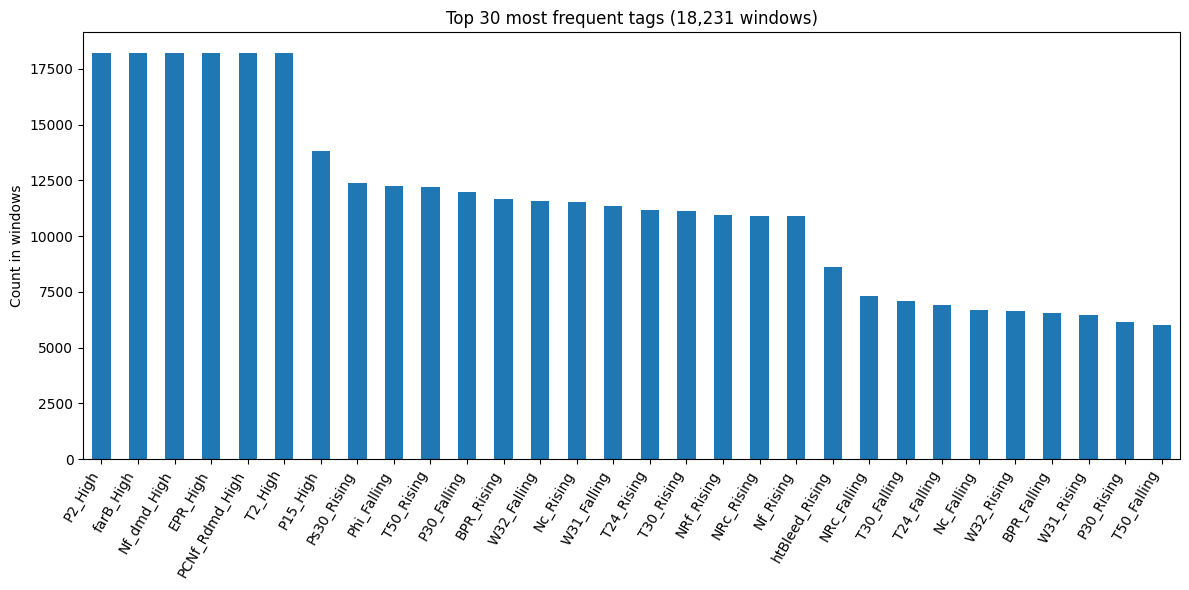

In [28]:
# Compte du nombre d’occurrences de chaque feature
freq = transactions_df.drop(columns=['label', 'unit', 'window_start']).sum().sort_values(ascending=False)
top_n = 30            # nombre de barres voulues
freq_head = freq.head(top_n)

plt.figure(figsize=(12, 6))
freq_head.plot(kind='bar')
plt.title(f"Top {top_n} most frequent tags ({len(transactions_df):,} windows)")
plt.ylabel("Count in windows")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


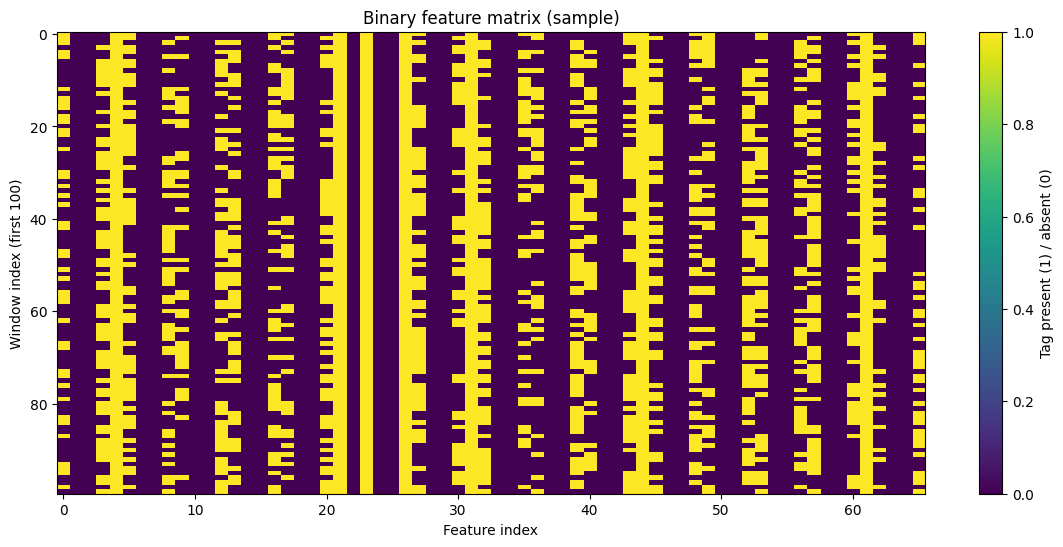

In [29]:
sample_size = 100     # on n’affiche que les 100 premières fenêtres
data = transactions_df.drop(columns=['label','unit','window_start']).iloc[:sample_size]

plt.figure(figsize=(14, 6))
plt.imshow(data.values, aspect='auto', interpolation='nearest')
plt.colorbar(label='Tag present (1) / absent (0)')
plt.xlabel("Feature index")
plt.ylabel("Window index (first 100)")
plt.title("Binary feature matrix (sample)")
plt.show()


Constant features: ['BPR_High', 'BPR_Low', 'EPR_High', 'NRc_High', 'NRc_Low', 'NRf_High', 'NRf_Low', 'Nc_High', 'Nc_Low', 'Nf_High', 'Nf_Low', 'Nf_dmd_High', 'P15_Falling', 'P15_High', 'P15_Low', 'P15_Rising', 'P2_High', 'P30_High', 'P30_Low', 'PCNf_Rdmd_High', 'Phi_High', 'Phi_Low', 'Ps30_High', 'Ps30_Low', 'T24_High', 'T24_Low', 'T2_High', 'T30_High', 'T30_Low', 'T50_High', 'T50_Low', 'W31_High', 'W31_Low', 'W32_High', 'W32_Low', 'farB_High', 'htBleed_High', 'htBleed_Low']


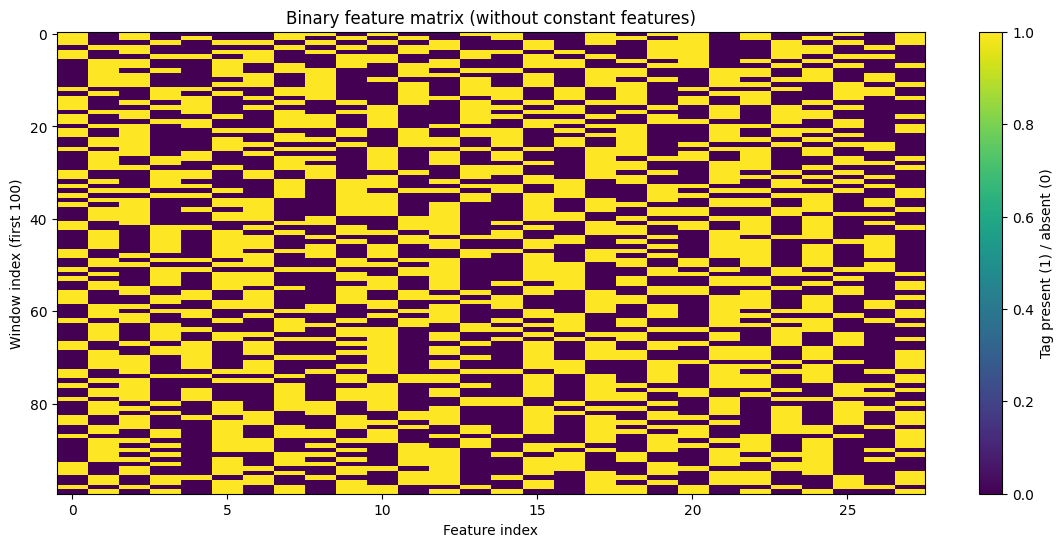

Original shape: (100, 66)
Cleaned shape: (100, 28)


In [30]:
# Get constant features
constant_features = data.columns[data.nunique() == 1]

# Print them
print("Constant features:", constant_features.tolist())

# Remove them
data_cleaned = data.drop(columns=constant_features)

# Plot the cleaned data
plt.figure(figsize=(14, 6))
plt.imshow(data_cleaned.values, aspect='auto', interpolation='nearest')  # Use data_cleaned instead of data
plt.colorbar(label='Tag present (1) / absent (0)')
plt.xlabel("Feature index")
plt.ylabel("Window index (first 100)")
plt.title("Binary feature matrix (without constant features)")
plt.show()

# Print the shape difference to verify removal
print(f"Original shape: {data.shape}")
print(f"Cleaned shape: {data_cleaned.shape}")